In [104]:
import pandas as pd
import numpy as np

### Version control documentation
# v1.1 - wrote concatenate_program_details() function
# to create "Full name" column at end of csv

# v1.2 - isolating top 10 most enrolled programs in a given year in order to make a 10x10 heatmap matrix
# also, cleaned up mark_enrollments() function by moving data wrangling process to occur inside the function

# v1.3 - refactored code to make this one function that takes in several inputs 
# (ex: csv file of data, start year, grade cutoff, number of progs, etc.)
# and outputs an n x n dataframe that can be visualized in a heatmap

In [105]:
# helper functions to help prep and filter the original Aft Program data frame

def concatenate_program_details(row):
    '''
    Function to concatenate important program details into a single string
    This function is used to add a 'Full Name' column to the aps data frame.

    Args:
        row (pd.Series) : A Pandas Series corresponding to a single row of a DataFrame. 
            It should contain the columns 'Program (Gender)', 'Program (Level)', 
            and 'Program (name)', from which non-NaN values will be concatenated.
    
    Returns:
        str : A string formed by concatenating the non-NaN values of 'Program (Gender)', 
            'Program (Level)', and 'Program (name)' columns, separated by spaces. 
            Returns an empty string if all specified columns contain NaN values.
    '''
    # List to hold the non-NaN values
    details = []

    for column in ['Program (Gender)', 'Program (Level)', 'Program (name)']:
        # Append the value if it is not NaN
        if pd.notna(row[column]):
            details.append(row[column])
    # Join the details with a space and return
    return ' '.join(details)


def filter_top_progs(df, start_yr=2010, end_yr=2022, start_gr=9, end_gr=12, n=15):
    '''
    Args:
        df (pd.Dataframe) : afternoon program dataframe to be filtered
        start_yr (int) : begin filtering df starting in this year (inclusive).  Default is 2010
        end_yr (int) : stop filtering df in this year (inclusive).  Default is 2022
        start_gr (int) : start grade (inclusive).  Default is 9th grade.
        end_gr (int) : end grade (inclusive).  Default is 12th grade
        n (int) : Filter by top n most enrolled programs.  Default is top 10 progs.

    Return:
        aps_top (pd.Dataframe) : a dataframe filtered using the above parameters with the top n programs
    '''
    
    # add a column at end of df of program 'Full name'
    df['Full name'] = df.apply(concatenate_program_details, axis=1)

    # apply filters
    aps_top = df[(df['Acad Yr (start)'] >= start_yr) 
               & (df['Acad Yr (start)'] <= end_yr)
               & (df['Grade at Time of Activity'] >= start_gr)
               & (df['Grade at Time of Activity'] <= end_gr)]
    
    # Create an array of the top enrolled programs
    top_enrolled_progs = aps_top['Full name'].value_counts().head(n).index

    # Filter the DataFrame to only keep top_enrolled_programs
    aps_top = aps_top[aps_top['Full name'].isin(top_enrolled_progs)]

    return aps_top

In [106]:
# checking dataframe prepping functions from above
aps = pd.read_csv('data/AP cleaned (v3).csv')
aps_top = filter_top_progs(aps, n=12)   # adjust size of n x n matrix here!
# aps_top['Full name'].unique()       # uncomment to display array of top n programs
# aps_top                           # uncomment to display aps_top df

In [107]:
# helper function to help convert aps_top df into an enrollment matrix

def mark_enrollments(aps_top):
    '''
    Data wrangling function that generates an enrollments matrix.
    Creates a df so that each row in a unique Person ID
    and the columns are the top_enrolled_progs

    1 = enrolled, 0 = not enrolled
    '''
    # create array of all unique students from aps_top
    person_ID_array = aps_top['Person ID'].unique()

    # initialize a Data Frame with all the Person ID's as first column
    matrix = pd.DataFrame(person_ID_array, columns= ["Person ID"])

    # fill rest of matrix with 0's and column_titles
    column_titles = aps_top['Full name'].unique()
    for column in column_titles:
        matrix[column] = 0
    
    for _, row in aps.iterrows():
        person_id = row['Person ID']
        program = row['Full name']
        
        # Check if the program exists in the matrix columns to avoid KeyError
        if program in matrix.columns:
            # Find the index in matrix where Person_ID matches and set the program column to 1
            matrix.loc[matrix['Person ID'] == person_id, program] = 1

    return matrix

In [108]:
# checking matrix prepping function from above
matrix = mark_enrollments(aps_top)
matrix      # each row should be a personID and will contain 1's for any enrolled programs in their time at school

,Person ID,Community Service,Girls Varsity Crew,Boys Varsity Crew,Girls Varsity Cross Country,Boys Varsity Cross Country,Boys Varsity Football,Junior Exempt,Boys Varsity Lacrosse,Musical,Senior Exempt,Strength and Conditioning,Technical Theater
0,24609,1,1,0,0,0,0,1,0,1,1,1,0
1,17660,1,0,0,0,0,0,0,0,0,1,1,0
2,16482,1,0,0,0,0,0,1,0,0,1,1,0
3,19577,1,0,0,0,0,0,1,0,0,1,0,0
4,24643,1,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,241166,0,0,0,0,0,0,0,0,0,0,0,1
1951,270836,0,0,0,0,0,0,0,0,1,0,0,0
1952,266275,0,0,0,0,0,0,0,0,1,0,0,0
1953,264998,0,0,0,0,0,0,0,0,1,0,0,0


In [109]:
# helper functions to run Cramer's V test and create a correlation matrix
# Source: cramers_v function directly from chatGPT 

from scipy.stats import chi2_contingency
import itertools

def cramers_v(x, y):
    '''
    Calculate Cramer's V statistic for any two pairwise columns of a DataFrame.
    '''
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    
    return (phi2_corr / min((k_corr-1), (r_corr-1)))**0.5


def generate_cramers_results(matrix):
    '''
    Given an enrollment matrix, this function will calculate all pairwise 
    Cramer's V test for any two columns of the input DataFrame.

    Args:
        matrix (pd.Dataframe) - enrollment matrix each row is a unique person ID,
            columns are the different top programs to compare.
            and '1's to mark all of their enrollments while at the school
    Returns:
        cramers_v_results (dict) : dictionary of all pairwise programs and their Cramer's V coefficients
            keys (tuple) - (program1 , program 2)
            value (float) - Cramer's V coefficient (0 = no association, 1 = pure association)
    '''
    # Drop the 'Person ID' column to focus on program columns only
    matrix = matrix.drop("Person ID", axis= 1)

    # Generate all unique pairs of programs
    program_columns = matrix.columns
    pairs = list(itertools.combinations(program_columns, 2))

    # Calculate Cramer's V for each pair and store the results
    # could store results in a dictionary
    cramers_v_results = {}
    for program1, program2 in pairs:
        cv = cramers_v(matrix[program1], matrix[program2])
        cramers_v_results[(program1, program2)] = cv

    return cramers_v_results

In [110]:
# checking cramer's V helper functions from above
cramers_v_results = generate_cramers_results(matrix)
# cramers_v_results                     # uncomment to check dict

In [111]:
# helper function to create heatmap matrix!

def generate_heatmap_matrix(aps_top, cramers_v_results):
    '''
    Args:
        aps_top (pd.Dataframe) : filtered afternoon program dataframe (return from filter_top_progs function)
        cramers_v_results (dict) : dictionary of all pairwise cramer's V tests (return from generate_cramers_v function)

    Returns:
        heatmap_df (pd.Dataframe) : n x n matrix where each cell is the Cramer's V coeffiecient between two progs
    '''
    # extract all program names (to populate row and column variables)
    top_enrolled_progs = aps_top['Full name'].unique()

    # Initialize the DataFrame
    heatmap_df = pd.DataFrame(index=top_enrolled_progs, columns=top_enrolled_progs)

    # Fill the diagonal with 1s for perfect self-correlation
    np.fill_diagonal(heatmap_df.values, 1)

    # Populate the DataFrame with Cramer's V results
    for (program1, program2), cv_value in cramers_v_results.items():
        heatmap_df.at[program1, program2] = cv_value
        heatmap_df.at[program2, program1] = cv_value  # Fill symmetric value

    # Replace any NaN values with 0 (for pairs without direct comparison, if any)
    heatmap_df = heatmap_df.fillna(0)

    # Ensure the data is of float type for heatmap compatibility
    heatmap_df = heatmap_df.astype(float).round(4)

    return heatmap_df

In [112]:
# checking heatmap helper function from above
heatmap_df = generate_heatmap_matrix(aps_top, cramers_v_results)
heatmap_df

,Community Service,Girls Varsity Crew,Boys Varsity Crew,Girls Varsity Cross Country,Boys Varsity Cross Country,Boys Varsity Football,Junior Exempt,Boys Varsity Lacrosse,Musical,Senior Exempt,Strength and Conditioning,Technical Theater
Community Service,1.0000,0.0750,0.1268,0.0869,0.0809,0.0772,0.0702,0.0413,0.0936,0.1106,0.0000,0.0000
Girls Varsity Crew,0.0750,1.0000,0.0672,0.2256,0.1019,0.1131,0.0623,0.0864,0.0000,0.0542,0.0000,0.0364
Boys Varsity Crew,0.1268,0.0672,1.0000,0.0064,0.2806,0.0000,0.0807,0.0801,0.0060,0.0617,0.0000,0.0000
Girls Varsity Cross Country,0.0869,0.2256,0.0064,1.0000,0.1062,0.1178,0.0540,0.0969,0.0000,0.0260,0.0633,0.0499
Boys Varsity Cross Country,0.0809,0.1019,0.2806,0.1062,1.0000,0.0735,0.1009,0.0405,0.0000,0.0970,0.0224,0.0138
Boys Varsity Football,0.0772,0.1131,0.0000,0.1178,0.0735,1.0000,0.0000,0.2570,0.0798,0.0000,0.0127,0.0979
Junior Exempt,0.0702,0.0623,0.0807,0.0540,0.1009,0.0000,1.0000,0.0248,0.0675,0.3053,0.1338,0.0162
Boys Varsity Lacrosse,0.0413,0.0864,0.0801,0.0969,0.0405,0.2570,0.0248,1.0000,0.1047,0.0502,0.0000,0.1082
Musical,0.0936,0.0000,0.0060,0.0000,0.0000,0.0798,0.0675,0.1047,1.0000,0.1274,0.1997,0.1520
Senior Exempt,0.1106,0.0542,0.0617,0.0260,0.0970,0.0000,0.3053,0.0502,0.1274,1.0000,0.1179,0.0872


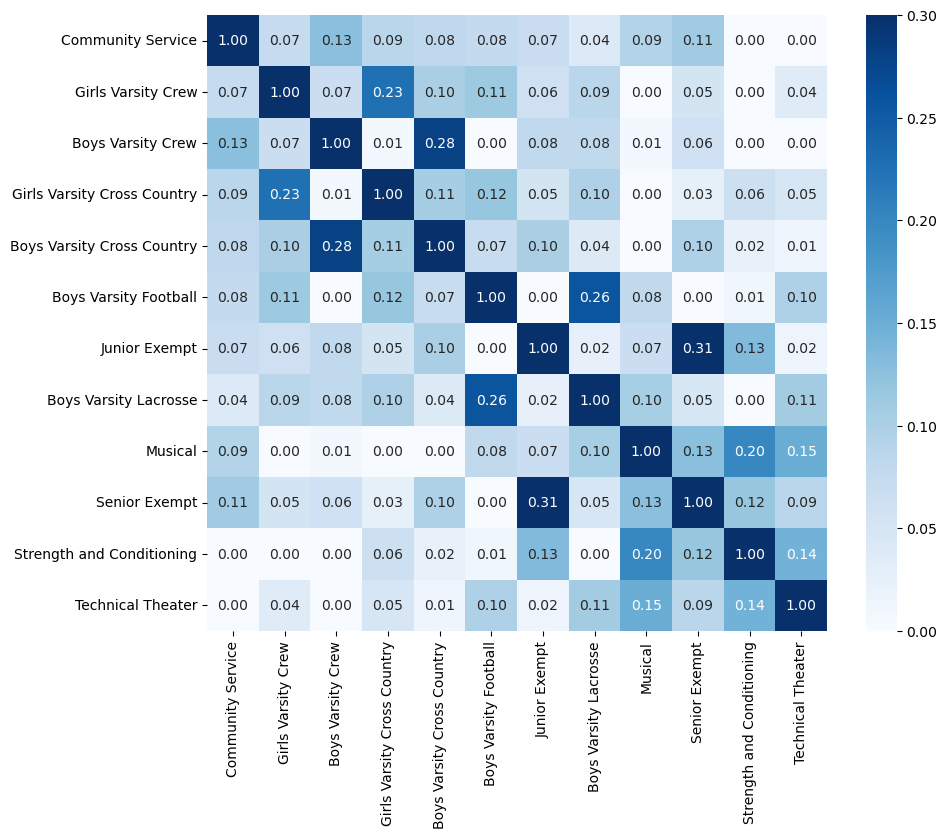

In [113]:
# quick test using seaborn!
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='Blues', fmt=".2f", vmin=0, vmax=0.30)
plt.show()